In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from matplotlib.colors import ListedColormap
import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp

import pickle
import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse



from os.path import isfile
import json



# load path_figures from config_user.json if it exists
path_config = "../config_user.json"
if isfile(path_config):
    with open(path_config, 'r') as f:
        config = json.load(f)
else:
    with open("../config_default.json", 'r') as f:
        config = json.load(f)

path_figures = config["path_figures"]
print(path_figures)



./figures/


In [2]:
savefig_args = {
    'transparent': True,
    'format': 'pdf',
    'dpi': 300,
    'facecolor': 'none',
    'bbox_inches': 'tight',
    'pad_inches': 0
}
#mm to inches conversion
def mm_to_inches(mm):
    return mm / 25.4

In [3]:

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold


    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks



In [4]:

def AP_step(u, v, N, a, b, e,mu1, mu2, c, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - u*v 
    dv = (e+mu1*v/(mu2+u)) * ( - v-a*u*(u-c-1))
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=8, b=0.05, e=1e-2, Du=0.04,mu1=0.05, mu2=0.3, c=0.1, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Nconf=3000, key=random.PRNGKey(2)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Nconf
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter, u_saved, v_saved = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = AP_step(u, v, N, a, b, e, mu1, mu2,c, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        u_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda u_saved: u_saved.at[save_counter // save_interval - 1].set(u),
                               lambda u_saved: u_saved,
                               u_saved)
        v_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda v_saved: v_saved.at[save_counter // save_interval - 1].set(v),
                               lambda v_saved: v_saved,
                               v_saved)
        
        return (u, v, key, save_counter, u_saved, v_saved), (u, v)

    # Preallocate arrays for saved configurations
    u_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    v_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    
    # Create a range of steps
    steps = jnp.arange(num_steps)
    
    # Run the scan function
    carry = (u, v, key, 0, u_saved, v_saved)
    carry, _ = lax.scan(scan_fn, carry, steps)

    u_saved = carry[4]
    v_saved = carry[5]

    return u_saved, v_saved

In [5]:
#here number of lattice points is the same as in the order parameter simulation, could be decreased
N_y=200
N_x=200
N=N_x*N_y

# healthy laplacian
L1, c1 = generate_laplacian(N_x,N_y,0, seed=1000, sparse_matrix=True)


In [47]:
#healthy heart simulation
u_sol_health, v_sol_health = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1,Du=0.008, mu1=0.01, key=random.PRNGKey(2),delta_t=0.1, total_time=1300, stimulus_time=1300,  Nconf=1300)
#Arrhythmia simulation
#u_sol_health=u_sol_health.T

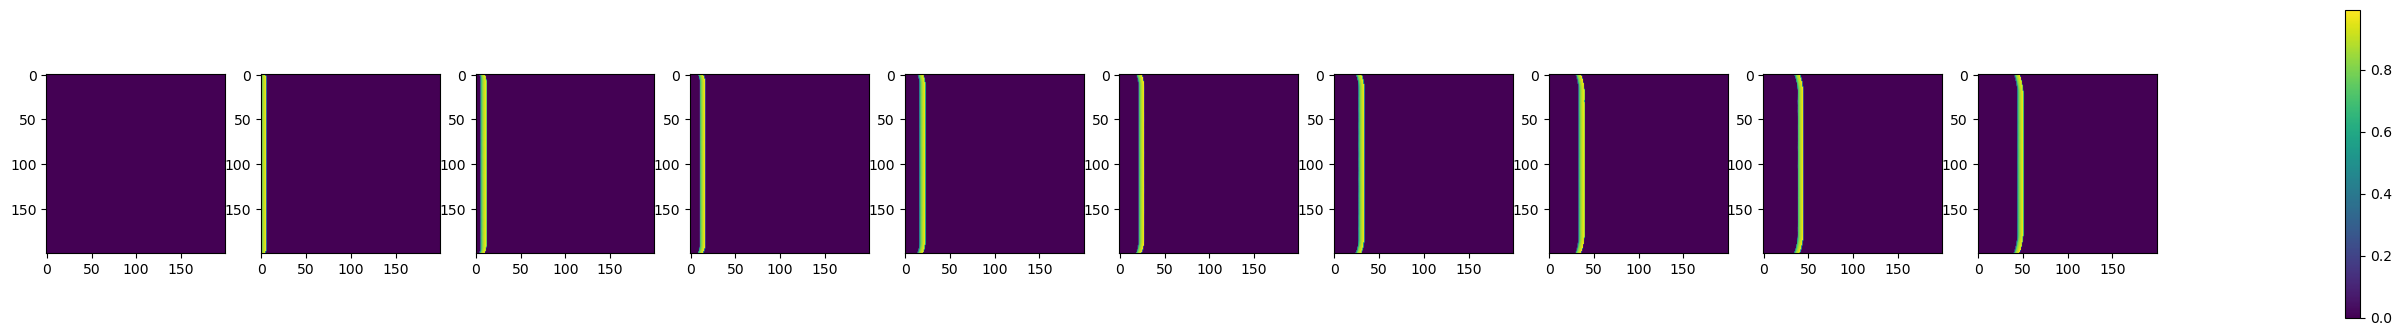

In [50]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = u_sol_health.min()
max = u_sol_health.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol_health[int((i/len(axs)*1300)),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

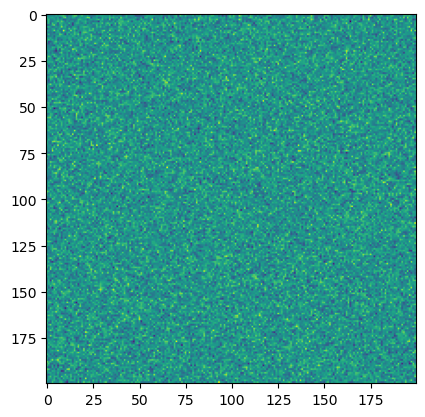

In [40]:
plt.imshow(u_sol_health[400,:N].reshape(N_x,N_y))

(80000,)


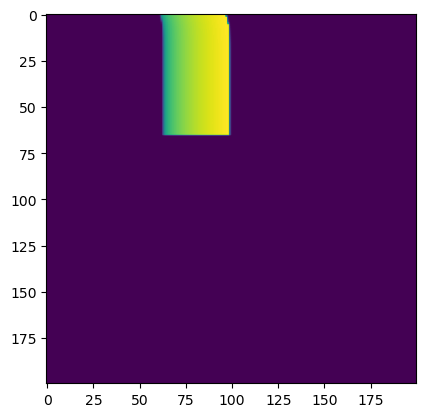

In [17]:
endstate=u_sol_health[400,:]
endu = endstate.reshape(N_x, N_y)

initu = endu.at[N_y//3:, :].set(0)
plt.imshow(initu)
initu = initu.flatten()
initv = v_sol_health[400,:]
y1 = jnp.append(initu,initv)
y1=jnp.array(y1)
print(y1.shape)

In [51]:
#healthy heart simulation
u_sol_health, v_sol_health = run_simulation(N=N, sigma=0.0001,L=L1,y0=y1, b=0.05, c1=c1,Du=0.3, mu1=0.01, key=random.PRNGKey(2),delta_t=0.1, total_time=5600, stimulus_time=800,  Nconf=5600)
#Arrhythmia simulation
#u_sol_health=u_sol_health.T

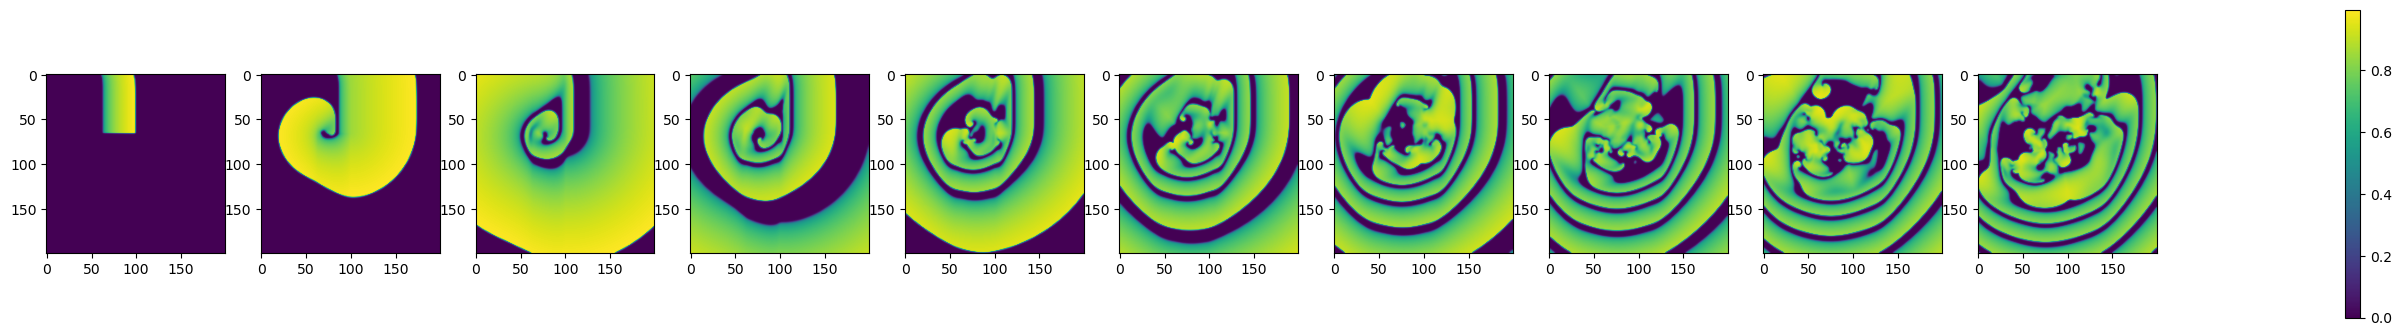

In [52]:
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = u_sol_health.min()
max = u_sol_health.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol_health[int((i/len(axs)*1000)),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

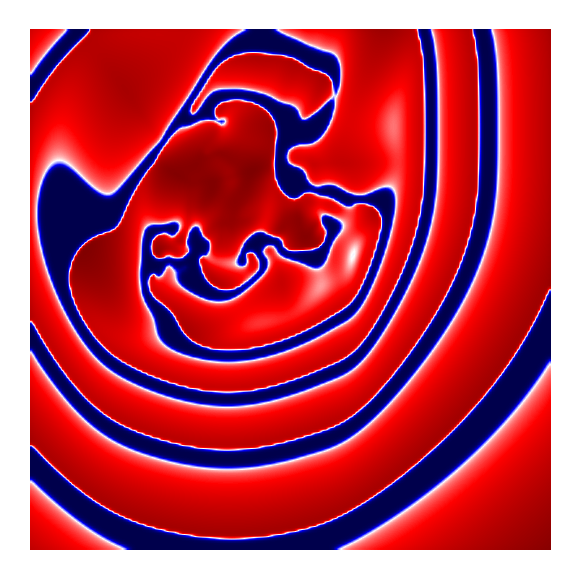

In [58]:
height_mm=45
width_mm=45
plt.figure(figsize=(mm_to_inches(width_mm), mm_to_inches(height_mm)), facecolor='none', dpi=300)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.imshow(u_sol_health[600,:N].reshape(N_x,N_y), cmap='seismic', vmin=np.min((u_sol_health[600,:N])), vmax=np.max(np.abs(u_sol_health[600,:N])), rasterized=True, aspect='auto', interpolation='bilinear')
plt.xticks([])  
plt.yticks([])  
#plt.ylabel("Excitable cells", fontsize=16)
#plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().set_rasterized(True)
plt.savefig('Aliev_Panfilov_2D_diffusion_chaos.pdf', **savefig_args)
plt.show()